In [1]:
import os
import time
import shutil
import pickle

import torch
import torch.nn.functional as F

from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from tensorboard_logger import configure, log_value

from model import RecurrentAttention
from utils import AverageMeter

from torchvision import transforms, utils, models
from PIL import Image

import torch

import utils
import data_loader

from trainer import Trainer
from config import get_config

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import pandas as pd

import json

In [2]:
def load_inputs(impath):
    to_tens = transforms.ToTensor()
    return to_tens(Image.open(impath).convert('RGB')).unsqueeze(0)

In [3]:
# class miniConv(torch.nn.Module):
#     def __init__(self, resnet):
#         super().__init__()
        
#         self.conv1 = resnet.conv1
#         self.bn1 = resnet.bn1
#         self.relu = resnet.relu
#         self.maxpool = resnet.maxpool
#         self.layer1 = resnet.layer1
#         self.adp_pool = torch.nn.AdaptiveAvgPool2d((1,1))
        
#     def forward(self, x):
        
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         x = self.adp_pool(x)
#         x = x.flatten(start_dim = 1)
#         return x
        

In [4]:
# model = miniConv(resnet = torchvision.models.resnet18())
# test = torch.rand(1,3, 256, 256)
# model(test).shape

In [5]:
# import torchvision

# torchvision.models.resnet18()

In [6]:
# type(mig_data)

In [7]:
m = open("../../pooling/data/migration_data.json",)
mig_data = json.load(m)
m.close()
mig_data = pd.DataFrame.from_dict(mig_data, orient = 'index').reset_index()
mig_data.columns = ['muni_id', 'num_migrants']
q = 2
mig_data['class'] = pd.qcut(mig_data['num_migrants'], q = q, labels = [i for i in range(q)])
mig_data

,muni_id,num_migrants,class
0,484001001,42055.0,1
1,484001002,4017.0,1
2,484001003,11992.0,1
3,484001004,762.0,1
4,484001005,7551.0,1
...,...,...,...
2326,484032049,2487.0,1
2327,484032050,2024.0,1
2328,484032051,3084.0,1
2329,484032052,2919.0,1


In [8]:
mig_data['class'].value_counts()

0    1166
1    1165
Name: class, dtype: int64

In [9]:
def get_png_names(directory):
    images = []
    for i in os.listdir(directory):
        try:
            if os.path.isdir(os.path.join(directory, i)):
                new_path = os.path.join(directory, i, "pngs")
                image = os.listdir(new_path)[0]
                images.append(os.path.join(directory, i, "pngs", image))
        except:
            pass
    return images


            

image_names = get_png_names("../../pooling/data/MEX/")

ys = []
for i in image_names:
        dta = mig_data[mig_data["muni_id"] == i.split("/")[5]]
        if len(dta) != 0:
            ys.append(dta['class'].values[0])

In [10]:
import matplotlib.pyplot as plt
import torchvision

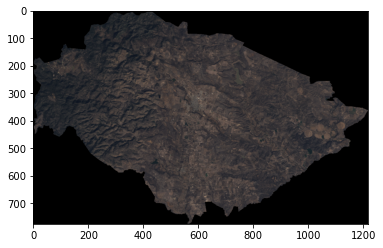

In [11]:
test_im = load_inputs(image_names[0])

plt.imshow(torchvision.transforms.functional.adjust_brightness(test_im, 2)[0].permute(1,2,0))

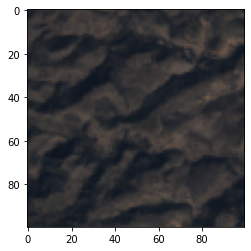

In [12]:
plt.imshow(torchvision.transforms.functional.adjust_brightness(test_im, 2)[0, :, 400:500, 200:300].permute(1,2,0))

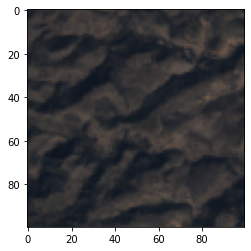

In [13]:
test_im_crop = torchvision.transforms.functional.adjust_brightness(test_im, 2)[0, :, 400:500, 200:300]
plt.imshow(test_im_crop.permute(1,2,0))

test_im_interploted = torch.nn.functional.interpolate(test_im_crop.unsqueeze(0), size = ([500, 500]), mode = 'nearest')

In [14]:
test_im_crop.shape

torch.Size([3, 100, 100])

In [15]:
import random

# train_num = int(25 * .70)

# train_indices = random.sample(range(0, 25), train_num)
# val_indices = [i for i in range(0, 25) if i not in train_indices]



import random

train_num = int(25 * .70)

train_indices = random.sample(range(0, 25), train_num)
val_indices = [i for i in range(0, 25) if i not in train_indices]

In [16]:
# val_indices

In [17]:
import torchvision

batch_size = 1

# train = [(load_inputs(image_paths[i]).squeeze()[:, 0:28, 0:28], ys[i]) for i in range(0, 93)]
# val = [(load_inputs(image_paths[i]).squeeze()[:, 0:28, 0:28], ys[i]) for i in range(93, 133)]

# brighten = torchvision.transforms.functional.adjust_brightness(brightness_factor = 2)


train = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), ys[i]) for i in train_indices]
val = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), ys[i]) for i in val_indices]


train_dl = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_dl = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

In [18]:
print("Num training: ", len(train_dl))
print("Num validation: ", len(val_dl))

Num training:  17
Num validation:  8


In [19]:
import numpy as np
from utils import plot_images

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [20]:
config, unparsed = get_config()

In [21]:
trainer = Trainer(config, (train_dl, val_dl))

In [22]:
# test = torch.rand(1,3,50,50)
# test = test.view(test.shape[0], -1)
# test.shape

In [25]:
# for i,o in train_dl:
#     print(i.shape)
#     adsga

In [26]:
trainer.train()

0.1s - loss: 0.759 - acc: 0.000:   6%|▌         | 1/17 [00:00<00:01,  8.97it/s]


[*] Train on 17 samples, validate on 8 samples

Epoch: 1/200 - LR: 0.000300


1.7s - loss: 1.005 - acc: 100.000: 100%|██████████| 17/17 [00:01<00:00,  9.85it/s]


train loss: 1.268 - train acc: 47.059 - val loss: 1.005 - val acc: 62.500 - val err: 37.500 [*]


0.2s - loss: 0.949 - acc: 100.000:  12%|█▏        | 2/17 [00:00<00:00, 15.78it/s]


Epoch: 2/200 - LR: 0.000300


  0%|          | 0/17 [00:00<?, ?it/s]

train loss: 0.954 - train acc: 58.824 - val loss: 0.931 - val acc: 62.500 - val err: 37.500

Epoch: 3/200 - LR: 0.000300


  0%|          | 0/17 [00:00<?, ?it/s]

train loss: 0.956 - train acc: 47.059 - val loss: 0.956 - val acc: 62.500 - val err: 37.500

Epoch: 4/200 - LR: 0.000300


  0%|          | 0/17 [00:00<?, ?it/s]

train loss: 1.000 - train acc: 58.824 - val loss: 0.981 - val acc: 50.000 - val err: 50.000

Epoch: 5/200 - LR: 0.000300


0.1s - loss: 0.959 - acc: 0.000:   6%|▌         | 1/17 [00:00<00:15,  1.04it/s]


KeyboardInterrupt: 

In [19]:
un = []

for i,o in val_dl:
    if o not in un:
        un.append(o)
        
un

[tensor([1]), tensor([0])]

In [20]:
trues, preds = [], []

for i,o in train_dl:
    trues.append(o.item())
    preds.append(trainer.predict(1, i, o))

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [22]:
confusion_matrix(trues, preds)

array([[397, 229],
       [183, 395]])

In [23]:
accuracy_score(trues, preds)

0.6578073089700996

In [24]:
trues, preds = [], []

for i,o in val_dl:
    trues.append(o.item())
    preds.append(trainer.predict(1, i, o))

In [25]:
confusion_matrix(trues, preds)

array([[180,  89],
       [ 76, 172]])

In [26]:
accuracy_score(trues, preds)

0.6808510638297872